In [16]:
from typing import List

from oop_functions.experiment_helper import *
from oop_functions.experiment_runner import ExperimentRunner
from oop_functions.util_functions import summarize_features, print_df, convert_numeric_to_float16
from oop_functions.visualization_util import *
from oop_functions.analytics_cv_util import *

%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

import itertools


In [17]:
processed_data = pd.read_csv('./processed_dataset/recent_propagated_dataset.csv', index_col=0)

In [18]:
# TODO: convert to float16

processed_data = convert_numeric_to_float16(processed_data)

## Merging Datasets

I realized that I was doing labeled mean imputation, which should not happen. So, I performed imputation after I merged cancer and no_cancer datasets back together. Without labeled mean imputation, gaussian NB and logistic regression do not perform well. 

run experiments with decision tree and remove the top feature every time. Store the depth of the tree, the efficacy of the top feature, its value, accuracy, confusion matrix

https://stackoverflow.com/questions/62819569/how-to-return-the-features-that-used-in-decision-tree-that-created-by-decisiontr

`TODO:` divide them as FP and FN?

`TODO:` only keep columns with more than 1 unique value? 

`TODO:` make spreadsheet with model performance for 1,3,5,10 years. Print out trees, top 5 features. Send models

`TODO:` try SVM or ML models

`TODO:` At what point they were misclassified (e.g. at what point they diverge compared to the similar point with different prediction.) Look at the nearest neightbors with different neightbors. 

In [19]:
def isin_filter(df: pd.DataFrame, col: str, values: List):
    return df[df[col].isin(values)]

# filtered_on = list(itertools.chain.from_iterable([zip([key]*len(vals), vals) for key, vals in differentiate_confusion_matrix_over.items()]))
# TODO: finish this one
differentiate_confusion_matrix_over = {
    'was_screened': [
        ([0], lambda df: isin_filter(df, 'was_screened', [0])), 
        ([1], lambda df: isin_filter(df, 'was_screened', [1]))
    ], 
    'ovar_histtype': [
        ([2], lambda df: isin_filter(df, 'ovar_histtype', [2])), 
        ([2, 4, 6, 8, 9, 31], lambda df: isin_filter(df, 'ovar_histtype', [2, 4, 6, 8, 9, 31]))
    ]
}


In [20]:
cv_analytics_utils = {}

In [21]:
classifiers = {
    # 'LogisticRegression': LogisticRegression(C= 0.25, random_state= 0),
    # 'GaussianNB': GaussianNB(var_smoothing= 1e-09),
    # 'DecisionTreeClassifier': DecisionTreeClassifier(criterion= 'entropy'),
    # 'RandomForestClassifier': RandomForestClassifier(criterion= 'entropy', n_estimators= 200),
    'XGBClassifier': XGBClassifier(eval_metric= 'error', learning_rate= 0.1)
}

experiment_data_helpers: List[ExperimentDataHelper] = [
    # ExperimentDataHelperSingleLabelScreenedFirst5,
    ExperimentDataHelperScreenedFirst5,
    ExperimentDataHelperScreenedColsFirst5,
    # ExperimentDataHelperScreenedOrCancer,
    # ExperimentDataHelperScreened,
    # ExperimentDataHelperNotScreenedCols,
    ExperimentDataHelperScreenedCols,
    # ExperimentDataHelperAll,
    # ExperimentDataHelperSingleLabelScreenedOrCancer,
    # ExperimentDataHelperSingleLabelScreened,
    # ExperimentDataHelperSingleLabelNotScreenedCols,
    # ExperimentDataHelperSingleLabelScreenedCols,
    # ExperimentDataHelperSingleLabelAll
]

In [22]:
# TODO: save propagated source df so that propagation does not have to happen all the time

In [23]:
years = [1]
num_folds=15
test_n_folds=15
train_size = 15000
for classifier_name, classifier in classifiers.items():
    for year in years:
        for experiment_data_helper_class in experiment_data_helpers:
            label = f'cancer_in_next_{year}_years'
            filesuffix = f'experiment_{experiment_data_helper_class.get_name()}_{classifier_name}_for_{label}_{num_folds}_trials'
            print(filesuffix)
            experiment_data_helper: ExperimentDataHelper = experiment_data_helper_class(processed_data, label, ['cancer_'], train_size = train_size)
            # experiment_data_helper.set_train_size_to_max(num_folds)
            experiment_runner = ExperimentRunner(classifier, experiment_data_helper, num_folds=num_folds, test_n_folds=test_n_folds)
            cv_analytics_util = experiment_runner.run_experiment()
            cv_analytics_utils[filesuffix] = cv_analytics_util
            cv_analytics_util.store_cv_analytics_utils(filesuffix)


experiment_participants_screened_first_5_XGBClassifier_for_cancer_in_next_1_years_15_trials
experiment_participants_screened_cols_first_5_XGBClassifier_for_cancer_in_next_1_years_15_trials
experiment_screened_cols_XGBClassifier_for_cancer_in_next_1_years_15_trials


In [24]:
# cv_analytics_util.set_filter(differentiate_confusion_matrix_over['was_screened'][0][1])

In [25]:
for analytics_util in cv_analytics_util.analytics_utils: 
    print(analytics_util.get_report_generation_util().get_roc_threshold())

0.18419167399406433
0.29902514815330505
0.20515704154968262
0.25794151425361633
0.2219659388065338
0.36895355582237244
0.27381622791290283
0.4650047719478607
0.15431778132915497
0.36025261878967285
0.3260687291622162
0.45406994223594666
0.1968572586774826
0.17661583423614502
0.30688342452049255


In [26]:
# for key, cv_analytics_util in cv_analytics_utils.items():
#     print(f"{key}: ")
#     filepath = f'./trees/decision_tree_for_{key}.png'
#     cv_analytics_util.analytics_utils[0].plot_save_tree(False, filepath)

experiment_participants_screened_first_5_XGBClassifier_for_cancer_in_next_1_years_15_trials: 


Cross-Validation measures:
+--------------------+----------+-------------+-----------+----------+
|                    |     mean |         std |       min |      max |
|--------------------+----------+-------------+-----------+----------|
| precision__class_0 | 0.999621 | 0.000217265 | 0.999017  | 0.999911 |
| recall__class_0    | 0.996137 | 0.00148421  | 0.993363  | 0.998052 |
| f1-score__class_0  | 0.997875 | 0.000754989 | 0.996449  | 0.998936 |
| precision__class_1 | 0.102785 | 0.0698971   | 0.0131579 | 0.219512 |
| recall__class_1    | 0.496791 | 0.209088    | 0.153846  | 0.888889 |
| f1-score__class_1  | 0.165788 | 0.10414     | 0.0243902 | 0.333333 |
| accuracy           | 0.995762 | 0.00150311  | 0.992925  | 0.997876 |
| auc                | 0.961117 | 0.026265    | 0.897381  | 0.993915 |
+--------------------+----------+-------------+-----------+----------+


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


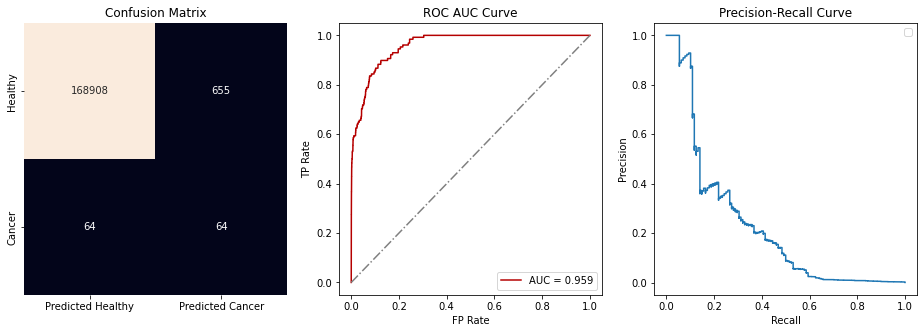

experiment_participants_screened_cols_first_5_XGBClassifier_for_cancer_in_next_1_years_15_trials: 


Cross-Validation measures:
+--------------------+-----------+-------------+----------+-----------+
|                    |      mean |         std |      min |       max |
|--------------------+-----------+-------------+----------+-----------|
| precision__class_0 | 0.999464  | 0.000251079 | 0.998883 | 0.999814  |
| recall__class_0    | 0.985841  | 0.00148471  | 0.98228  | 0.987909  |
| f1-score__class_0  | 0.992605  | 0.00076041  | 0.990969 | 0.993736  |
| precision__class_1 | 0.017341  | 0.0112381   | 0        | 0.0362319 |
| recall__class_1    | 0.321133  | 0.193387    | 0        | 0.75      |
| f1-score__class_1  | 0.0327405 | 0.0209763   | 0        | 0.0680272 |
| accuracy           | 0.985324  | 0.0014974   | 0.98211  | 0.987556  |
| auc                | 0.694063  | 0.140093    | 0.41989  | 0.908109  |
+--------------------+-----------+-------------+----------+-----------+


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


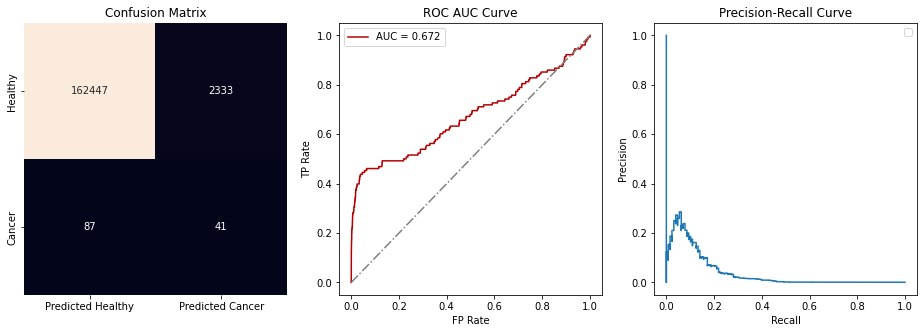

experiment_screened_cols_XGBClassifier_for_cancer_in_next_1_years_15_trials: 


Cross-Validation measures:
+--------------------+------------+------------+-------------+------------+
|                    |       mean |        std |         min |        max |
|--------------------+------------+------------+-------------+------------|
| precision__class_0 | 0.998664   | 0.00035954 | 0.997639    | 0.999136   |
| recall__class_0    | 0.859598   | 0.00775852 | 0.847234    | 0.873574   |
| f1-score__class_0  | 0.92391    | 0.00441491 | 0.916808    | 0.931494   |
| precision__class_1 | 0.00343904 | 0.00128886 | 0.000603865 | 0.00534125 |
| recall__class_1    | 0.298357   | 0.112113   | 0.0588235   | 0.473684   |
| f1-score__class_1  | 0.00679694 | 0.00254544 | 0.00119546  | 0.0105634  |
| accuracy           | 0.858678   | 0.00762178 | 0.846496    | 0.871824   |
| auc                | 0.637512   | 0.0817465  | 0.461399    | 0.779485   |
+--------------------+------------+------------+---------

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


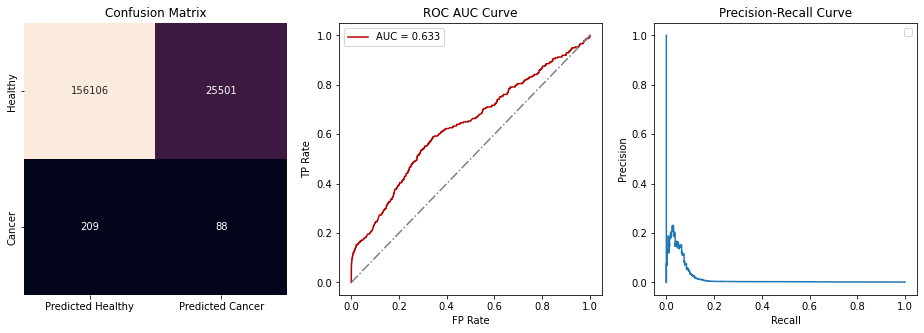

In [27]:
for key, cv_analytics_util in cv_analytics_utils.items():
    print(f"{key}: ")
    cv_analytics_util.update_thresholds(None)
    cv_analytics_util.get_cv_report();
    cv_analytics_util.display_graph()

In [28]:
cv_analytics_util.analytics_utils[0].data_util.train_df['ovar_histtype']

51425     10.570312
161599     2.000000
55322     10.570312
159579     2.000000
60424     34.000000
            ...    
64040      2.000000
68198      6.000000
27258     10.570312
13881     10.570312
103090    31.000000
Name: ovar_histtype, Length: 30000, dtype: float16

In [29]:
X_test_mismatch = cv_analytics_util.analytics_utils[0].get_high_confidence_errors()

In [30]:
false_negatives = pd.concat(np.array(X_test_mismatch)[:, 0])
false_negatives = false_negatives[false_negatives['cancer_in_next_1_years_prob'] < 0.14151879]
print_df(false_negatives)

TypeError: cannot concatenate object of type '<class 'numpy.float64'>'; only Series and DataFrame objs are valid

In [ ]:
len(false_negatives)

13

In [ ]:
print_df(pd.concat(X_test_mismatch[1][:2]))

+--------+-------+------------+-------------+-------+---------+-------+------------+-----------+-----------+-----------------+----------+-----------+----------+-----------+------------+------------+----------+-------------+-----------------+-----------------+--------------+------------+----------------+-----------------+----------+------------+------------+-------------+---------+-----------+---------------------+-----------+---------+---------+----------+----------+--------------+--------------+--------+--------+----------+------------+-----------------+-----------+-------------+--------------+-----------+--------------+------------+------------+--------------+----------+-------------+--------------+------------+-----------+--------+----------+-----------------------+-------------+-------------+---------+---------------------+-----------+-----------+-----------+-----------+-----------+----------+----------+-----------------+-----------+---------+-----------+---------------------+-----

In [ ]:
# drop col if the feature value of patient that was misclassified does not appear in the list of feature values of patients that were classified
df = pd.concat(X_test_mismatch[1][:2])
for col in df.columns:
    if df[col].iloc[0] in df[col].iloc[list(range(1, 6))].to_list():
        df.drop(col,inplace=True,axis=1)
print_df(df)
summary = summarize_features(df)

+--------+-------+-----------+----------+------------+------------+-------------+-----------+--------------+-----------+---------+-----------+--------------+---------------+-------------+--------------+---------------+--------------+---------+-------------+-----------+----------+------------+---------+--------------+--------------------------+-------------------------------+-------------------------------+------------+
|        |   age |   bcontrt |   bmi_20 |   bmi_curr |   cig_stop |   cig_years |   cigpd_f |   diabetes_f |   fchilda |   livec |   lmenstr |   ovary_diam |   ovary_diamr |   ovary_vol |   ovary_volr |   ovcyst_diam |   pack_years |   pregc |   rantero_p |   rtran_p |   rvol_p |   smokea_f |   thorm |   weight20_f |   cancer_in_next_1_years |   cancer_in_next_1_years_pred |   cancer_in_next_1_years_prob |   distance |
|--------+-------+-----------+----------+------------+------------+-------------+-----------+--------------+-----------+---------+-----------+------------

In [ ]:

df = pd.concat(X_test_mismatch[4][:2])
for col in df.columns:
    if len(df[col].unique()) <= 2:
        df.drop(col,inplace=True,axis=1)
print_df(df)
summary = summarize_features(df)
print_df(summary)

+--------+---------+-----------+-----------+----------+----------+------------+----------+------------+-----------------+----------+------------+------------+-------------+-----------+----------+------------+----------+-------------+---------+-----------+-----------+-----------+----------+-----------------+-----------+--------------+---------------+---------------+-------------+--------------+--------------+---------------+--------------+---------------+--------------+---------+-------------+-----------+-------------+-----------+----------+-----------+------------+-----------+--------------+--------------+------------+------------+
|        |   asppd |   bcontra |   bcontrt |   bmi_20 |   bmi_50 |   bmi_curr |   bq_age |   brothers |   ca125ii_level |   center |   cig_stat |   cig_stop |   cig_years |   cigpd_f |   educat |   height_f |   ibuppd |   lantero_p |   livec |   llong_p |   lmenstr |   ltran_p |   lvol_p |   mammo_history |   marital |   ovary_diam |   ovary_diaml |   ovary_